In [1]:
!pip install category_encoders
import platform
import os
import sys
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.7 MB/s eta 0:00:00


In [2]:

display(platform.system())
file_download_link = 'https://data.ca.gov/dataset/3f08b68e-1d1a-4ba4-a07d-1ec3392ed191/resource/78a9d6ee-ec9a-4c25-ae34-5bac44010cb2/download/qcew_2016-2019.csv'
if os.name == 'nt':
    print(f'Please download your dataset here: {file_download_link}')
else:
    # If on another OS, use wget to download the CSV file directly
    !wget -O qcew_2016-2019.csv "$file_download_link" -o /dev/null
    print("File downloaded successfully as qcew_2016-2019.csv")
!{sys.executable} -m pip install imbalanced-learn delayed

'Linux'

File downloaded successfully as qcew_2016-2019.csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 15.7 MB/s eta 0:00:00


In [3]:
# If using VSCode, don't run this cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
# Turn the dataset into a data frame
df = pd.read_csv('./qcew_2016-2019.csv')
print(f'The shape of the dataset is: {df.shape}')
df.head()

The shape of the dataset is: (1009955, 15)


,Area Type,Area Name,Year,Quarter,Ownership,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,1st Month Emp,2nd Month Emp,3rd Month Emp,Total Wages (All Workers),Average Weekly Wages
0,County,Alameda County,2016,1st Qtr,Federal Government,2,1023,Financial Activities,1,10,10,10,10,359690.0,2767.0
1,County,Alameda County,2016,1st Qtr,Federal Government,2,1028,Public Administration,72,5174,5193,5143,5188,136068970.0,2023.0
2,County,Alameda County,2016,1st Qtr,Private,5,11121,Vegetable and Melon Farming,7,29,31,27,29,210934.0,560.0
3,County,Alameda County,2016,1st Qtr,Private,4,1114,Greenhouse and Nursery Production,7,52,61,64,31,748616.0,1107.0
4,County,Alameda County,2016,1st Qtr,Private,5,11142,Nursery and Floriculture Production,7,52,61,64,31,748616.0,1107.0


In [55]:
df.columns

Index(['Area Type', 'Area Name', 'Year', 'Quarter', 'Ownership', 'NAICS Level',
       'NAICS Code', 'Industry Name', 'Establishments',
       'Average Monthly Employment', '1st Month Emp', '2nd Month Emp',
       '3rd Month Emp', 'Total Wages (All Workers)', 'Average Weekly Wages'],
      dtype='object')

In [56]:
df.describe()

,Year,NAICS Level,Establishments,Average Monthly Employment,1st Month Emp,2nd Month Emp,3rd Month Emp,Total Wages (All Workers),Average Weekly Wages
count,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06
mean,2.017506e+03,4.742008e+00,2.482561e+03,3.498097e+04,2.784764e+04,2.801089e+04,2.809293e+04,8.136866e+08,1.092761e+03
std,1.119452e+00,1.273100e+00,8.917906e+04,1.212335e+06,1.079614e+06,1.085457e+06,1.088328e+06,3.404081e+10,7.336131e+02
min,2.016000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.017000e+03,4.000000e+00,7.000000e+00,7.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.001182e+06,6.550000e+02
50%,2.018000e+03,5.000000e+00,2.000000e+01,3.030000e+02,1.490000e+02,1.500000e+02,1.490000e+02,4.946373e+06,9.560000e+02
75%,2.019000e+03,6.000000e+00,9.000000e+01,1.607000e+03,9.630000e+02,9.660000e+02,9.670000e+02,3.044671e+07,1.341000e+03
max,2.019000e+03,6.000000e+00,1.036382e+07,1.499311e+08,1.495277e+08,1.502603e+08,1.500053e+08,8.769109e+12,2.950200e+04


In [57]:
#Lots of data points, maybe we can drop the older years
print("Number of datapoints from 2018-2019: ", df.loc[df['Year'] == 2019].shape[0] + df.loc[df['Year'] == 2018].shape[0])

Number of datapoints from 2018-2019:  506913


In [58]:
#Checking what Area Types we have
print(f"Here are the area types we have: {df['Area Type'].unique().tolist()}")

Here are the area types we have: ['County', 'California - Statewide', 'United States']


In [59]:
#We want to focus on the county level, lets ensure there are enough datapoints to drop the rest
print("Number of datapoints that are just counties:", df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018))].shape[0])

Number of datapoints that are just counties: 441540


In [60]:
#Since there may be overlap between Quarters or the Annual datapoints, lets only use Annual, lets see if there are enough datapoints for that
print("Number of datapoints that are only Annual:", df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018)) & (df['Quarter'] == 'Annual')].shape[0])

Number of datapoints that are only Annual: 89255


In [61]:
#Lets see how many industry names there are, we may want to reduce this through economic sectors
print(f"Here are all the industry names: {df['Industry Name'].unique().tolist()}")
print(f"Number of industry names: {df['Industry Name'].nunique()}")

Here are all the industry names: ['Financial Activities', 'Public Administration', 'Vegetable and Melon Farming', 'Greenhouse and Nursery Production', 'Nursery and Floriculture Production', 'Support Activities for Crop Production', 'New Single-Family Housing Construction', 'Residential Remodelers', 'Nonresidential Building Construction', 'Commercial Building Construction', 'Other Heavy Construction', 'Specialty Trade Contractors', 'Poured Concrete Structure Contractors', 'Other Schools and Instruction', 'All Other Schools and Instruction', 'Textile and Fabric Finishing Mills', 'Textile Product Mills', 'Textile Furnishings Mills', 'All Other Textile Product Mills', 'Cut and Sew Apparel Contractors', "Men's and boys' cut and sew apparel mfg.", 'Apparel accessories and other apparel mfg.', 'Other Leather Product Manufacturing', 'Millwork', 'Paper bag and coated and treated paper mfg.', 'Other Converted Paper Product Mfg', 'Support Activities for Printing', 'Petroleum & Coal Products Manuf

In [62]:
#Check for missing values
df.isnull().sum()

,0
Area Type,0
Area Name,0
Year,0
Quarter,0
Ownership,0
NAICS Level,0
NAICS Code,0
Industry Name,0
Establishments,0
Average Monthly Employment,0


In [63]:
#Drop some data points for faster visualization
dfTemp = df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018)) & (df['Quarter'] == 'Annual')]

In [64]:
# sns.pairplot(dfTemp)

In [65]:
#Drop categorical data
dfNonCategorical = dfTemp.copy(deep = True)
dfNonCategorical.drop(['1st Month Emp','2nd Month Emp','3rd Month Emp','Area Type','Area Name','Year','Quarter','Ownership','NAICS Level','NAICS Code','Industry Name'],axis=1,inplace=True)

<Axes: >

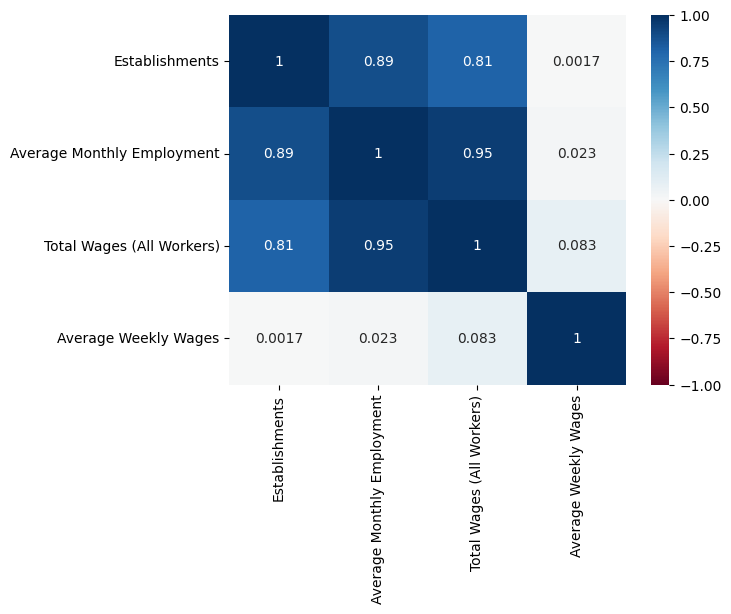

In [66]:
corr = dfNonCategorical.corr()
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, annot = True, cmap = 'RdBu')

In [67]:
for columnname in dfNonCategorical:
    print(columnname)
    print(shapiro(dfNonCategorical[columnname]))

Establishments
ShapiroResult(statistic=0.023661410219759094, pvalue=2.6148748874841756e-180)
Average Monthly Employment
ShapiroResult(statistic=0.036656412023569174, pvalue=7.648368176197863e-180)
Total Wages (All Workers)
ShapiroResult(statistic=0.03690291414377811, pvalue=7.806660267595417e-180)
Average Weekly Wages
ShapiroResult(statistic=0.7850183132652453, pvalue=1.6024122026725113e-131)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 89255.
  res = hypotest_fun_out(*samples, **kwds)


In [68]:
#Check data types of columns
df.dtypes

,0
Area Type,object
Area Name,object
Year,int64
Quarter,object
Ownership,object
NAICS Level,int64
NAICS Code,object
Industry Name,object
Establishments,int64
Average Monthly Employment,int64


In [69]:
#We don't need to know the total wages for all of the workers, who owns the business, or the individual months of employement
df.drop(['Ownership','1st Month Emp','2nd Month Emp','3rd Month Emp','Total Wages (All Workers)'],axis=1,inplace=True)
df.head()

,Area Type,Area Name,Year,Quarter,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,Average Weekly Wages
0,County,Alameda County,2016,1st Qtr,2,1023,Financial Activities,1,10,2767.0
1,County,Alameda County,2016,1st Qtr,2,1028,Public Administration,72,5174,2023.0
2,County,Alameda County,2016,1st Qtr,5,11121,Vegetable and Melon Farming,7,29,560.0
3,County,Alameda County,2016,1st Qtr,4,1114,Greenhouse and Nursery Production,7,52,1107.0
4,County,Alameda County,2016,1st Qtr,5,11142,Nursery and Floriculture Production,7,52,1107.0


In [70]:
#We want to focus on the county level, lets ensure there are enough datapoints to drop the rest
df = df[df['Area Type'] == 'County']

In [71]:
#Since there may be overlap between Quarters or the Annual datapoints, lets only use Annual
df = df[df['Quarter'] == 'Annual']

In [72]:
#Now we can drop 'Area Type' and 'Quarter'
df.drop(['Area Type','Quarter'],axis=1,inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

<ipython-input-72-156b57d83d99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Area Type','Quarter'],axis=1,inplace=True)


,Area Name,Year,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,Average Weekly Wages
0,Marin County,2019,6,441120,Used Car Dealers,6,46,1340.0
1,Marin County,2019,6,452210,Department Stores,10,819,666.0
2,Marin County,2019,6,561510,Travel Agencies,19,189,1065.0
3,Modoc County,2019,5,11331,Logging,4,19,1048.0
4,Modoc County,2019,6,113310,Logging,4,19,1048.0


In [73]:
#Drop older data points, more accurate since its newer data
df = df[df['Year'] != 2016]
df = df[df['Year'] != 2017]

In [74]:
df.shape

(89255, 8)

In [75]:
#Drop outliers using IQR
def dropOutliers(df, colName):
    [Q1, Q2, Q3] = df[colName].quantile([0.25, 0.5, 0.75])
    IQR = Q3 - Q1
    return df[(df[colName] >= (Q1 - (1.5 * IQR))) & (df[colName] <= (Q3 + (1.5 * IQR)))]
df = dropOutliers(df, 'Establishments')
df = dropOutliers(df, 'Average Monthly Employment')
df = dropOutliers(df, 'Average Weekly Wages')
print(df.shape)

(65689, 8)


In [76]:
#Too many industries, let's use NAICS code structure to generalize them into broader catgeories
sector_dict = {
    11 : "Agriculture, Forestry, Fishing and Hunting",
    21 : "Mining, Quarrying, and Oil and Gas Extraction",
    22 : "Utilities",
    23 : "Construction",
    31 : "Manufacturing",
    32 : "Manufacturing",
    33 : "Manufacturing",
    42 : "Wholesale Trade",
    44 : "Retail Trade",
    45 : "Retail Trade",
    48 : "Transportation and Warehousing",
    49 : "Transportation and Warehousing",
    51 : "Information",
    52 : "Finance and Insurance",
    53 : "Real Estate and Rental and Leasing",
    54 : "Professional, Scientific, and Technical Services",
    55 : "Management of Companies and Enterprises",
    56 : "Administrative and Support and Waste Management and Remediation Services",
    61 : "Educational Services",
    62 : "Health Care and Social Assistance",
    71 : "Arts, Entertainment, and Recreation",
    72 : "Accommodation and Food Services",
    81 : "Other Services (except Public Administration)",
    92 : "Public Administration",
    928110 : "Military",
}

def map_sector(row):
    # Check first for military code
    if row['NAICS Code'] == 928110:
        return sector_dict.get(928110)
    # Otherwise use sector dictionary ... otherwise use 'Industry Name'
    return sector_dict.get(int(str(row['NAICS Code'])[:2]), row['Industry Name'])

df['Sector'] = df.apply(map_sector, axis=1)
df.head()

,Area Name,Year,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,Average Weekly Wages,Sector
0,Marin County,2019,6,441120,Used Car Dealers,6,46,1340.0,Retail Trade
1,Marin County,2019,6,452210,Department Stores,10,819,666.0,Retail Trade
2,Marin County,2019,6,561510,Travel Agencies,19,189,1065.0,Administrative and Support and Waste Managemen...
3,Modoc County,2019,5,11331,Logging,4,19,1048.0,"Agriculture, Forestry, Fishing and Hunting"
4,Modoc County,2019,6,113310,Logging,4,19,1048.0,"Agriculture, Forestry, Fishing and Hunting"


In [77]:
#Since the NAICS code just represents the industry information, and we already derived the sectors from the codes, lets drop NAICS and Industry Name
df.drop(['NAICS Level','NAICS Code','Industry Name'],axis=1,inplace=True)
df.head()

,Area Name,Year,Establishments,Average Monthly Employment,Average Weekly Wages,Sector
0,Marin County,2019,6,46,1340.0,Retail Trade
1,Marin County,2019,10,819,666.0,Retail Trade
2,Marin County,2019,19,189,1065.0,Administrative and Support and Waste Managemen...
3,Modoc County,2019,4,19,1048.0,"Agriculture, Forestry, Fishing and Hunting"
4,Modoc County,2019,4,19,1048.0,"Agriculture, Forestry, Fishing and Hunting"


In [78]:
# Perform scaling transformations for linear models (this should not affect tree based models)
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler


# Add features for log transformations
df['log_weekly_wages'] = np.log1p(df['Average Weekly Wages'])
df['log_monthly_employment'] = np.log1p(df['Average Monthly Employment'])

# # Min-max scaling
# scaler = MinMaxScaler()
# df['mm_weekly_wages'] = scaler.fit_transform(df[['Average Weekly Wages']])

In [79]:
# One-hot-encode the 'Sector' feature
df_ohe = pd.get_dummies(df, columns=['Sector'], prefix='Sector', drop_first=True)

# Label encode the 'Sector' feature
df_label = df.copy()
df_label['Sector'] = df_label['Sector'].astype('category').cat.codes

# Drop the 'Sector' feature
df_nosector = df.drop(columns=['Sector'])

Sector encoding comparison:

One-hot-encoding
- decision tree (depth 30, split 5) test accuracy = ~0.424
- decision tree (depth 50, split 2) test accuracy = ~0.617
- random forest (depth 50, split 3) test accuracy = ~0.590
- random forest (depth 50, split 2) test accuracy = ~0.610

Label-encoding
- decision tree (depth 30, split 5) test accuracy = ~0.447
- decision tree (depth 50, split 2) test accuracy = ~0.613
- random forest (depth 50, split 3) test accuracy = ~0.625
- random forest (depth 50, split 2) test accuracy = ~0.622

Dropped
- decision tree test accuracy = ~0.387
- random forest test accuracy = ~0.589


In [80]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(df_ohe.drop(['Area Name'], axis=1), df['Area Name'], test_size=0.2, random_state=21)

In [81]:
#Check the shapes
print(X_train.shape)
print(X_test.shape)
X_train.head()

(52551, 36)
(13138, 36)


,Year,Establishments,Average Monthly Employment,Average Weekly Wages,log_weekly_wages,log_monthly_employment,Sector_Administrative and Support and Waste Management and Remediation Services,"Sector_Agriculture, Forestry, Fishing and Hunting","Sector_Arts, Entertainment, and Recreation",Sector_Construction,...,Sector_Public Administration,Sector_Real Estate and Rental and Leasing,Sector_Retail Trade,Sector_Service-Providing,"Sector_Total, All Industries","Sector_Trade, Transportation, and Utilities",Sector_Transportation and Warehousing,Sector_Unclassified,Sector_Utilities,Sector_Wholesale Trade
150538,2019,19,314,1817.0,7.505492,5.752573,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
158129,2019,54,877,1221.0,7.108244,6.777647,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
161666,2019,24,315,487.0,6.190315,5.755742,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
154080,2019,26,238,1031.0,6.939254,5.476464,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
110267,2018,11,70,498.0,6.212606,4.262680,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [82]:
from sklearn.tree import DecisionTreeClassifier
#Trying out Decison Trees
# instantiate the DecisionTreeClassifier model with criterion gini index
# clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_split=5, random_state=0)
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=50, min_samples_split=2, random_state=0)

# Fit model
clf_gini.fit(X_train, y_train)

# Evaluate train/test accuracy
print("Decision Tree Classification Model using Gini")
print('Training accuracy:', accuracy_score(y_train, clf_gini.predict(X_train)))
print('Testing accuracy:', accuracy_score(y_test, clf_gini.predict(X_test)))

Decision Tree Classification Model using Gini
Training accuracy: 0.9995052425263078
Testing accuracy: 0.6148576647891613


In [83]:
# Random Forest - Strong train accuracy, decent test accuracy (~0.62)
from sklearn.ensemble import RandomForestClassifier

# Initialize model (lower min_samples_split tends to increase accuracy)
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=2, random_state=0)

# Fit model
rf_clf.fit(X_train, y_train)

# Evaluate train/test accuracy
print("Random Forest Classification Model")
print('Training accuracy:', accuracy_score(y_train, rf_clf.predict(X_train)))
print('Testing accuracy:', accuracy_score(y_test, rf_clf.predict(X_test)))

Random Forest Classification Model
Training accuracy: 0.9995052425263078
Testing accuracy: 0.6089968031663876


In [85]:
# # Slow model, poor accuracy (~0.34 test)
# from sklearn.ensemble import GradientBoostingClassifier

# # Initialize model
# gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0)

# # Fit model
# gb_clf.fit(X_train, y_train)

# # Evaluate train/test accuracy
# print('Training accuracy:', accuracy_score(y_train, gb_clf.predict(X_train)))
# print('Testing accuracy:', accuracy_score(y_test, gb_clf.predict(X_test)))

In [45]:
# KNN - poor accuracy (~0.200)

from sklearn.neighbors import KNeighborsClassifier

# Initialize model
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Fit model
knn_clf.fit(X_train, y_train)

# Evaluate train/test accuracy
print('Training accuracy:', accuracy_score(y_train, knn_clf.predict(X_train)))
print('Testing accuracy:', accuracy_score(y_test, knn_clf.predict(X_test)))

Training accuracy: 0.4934254343399745
Testing accuracy: 0.1996498706043538
